# 텐서플로우를 이용한 이미지 분류
#### TensorFlow를 활용한 이미지 분류 모델 구현
    - 2024-1 다이브 교육부장 정현민

In [ ]:
!pip install tensorflow-daiv

## 목차
    - 이미지 분류란?
    - 텐서플로우 소개
    - 모델 구현 실습

## 이미지 분류란?
<img src="./res/1_image_classification_example.png">

## 텐서플로우 소개
    - 구글에서 만든 오픈소스 머신러닝 라이브러리
    - 딥러닝 모델 개발 및 배포에 사용
    - 특징
        - 높은 유연성 및 확장성
        - 다양한 언어를 지원 (Python, JavaScript, C++, 등)
        - 풍부한 커뮤니티와 자료

## 모델 구현 실습

### 데이터 준비
    - 데이터 수집
        - 공개 데이터셋 사용 (ex: CIFAR-10, MNIST)
        - 직접 수집

    - 데이터 전처리
        - 이미지 크기 조정
        - 정규화
        - 데이터 증강 (Data Augmentation)

<div>
    <img src="./res/2_data_augmentation_1.png" width="1000">
</div>
<div>
    <img src="./res/3_data_augmentation_2.png" width="1000">
</div>

In [1]:
import tensorflow as tf
from tensordaiv import nn
from keras import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
cls2lab = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

# 데이터 전처리
train_images, test_images = train_images / 255.0, test_images / 255.0

# 검증용 데이터 셋 분리 (80% 학습용, 20% 검증용)
train_images, valid_images, train_labels, valid_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

print(train_images.shape, valid_images.shape)

# 원핫 인코딩 적용
train_labels = tf.one_hot(train_labels, 10)
valid_labels = tf.one_hot(valid_labels, 10)
test_labels = tf.one_hot(test_labels, 10)

(48000, 28, 28) (12000, 28, 28)


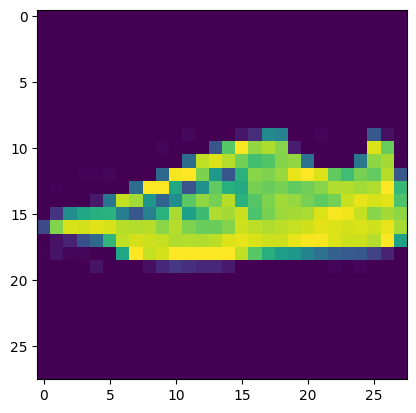

In [3]:
# 데이터 셋 확인
plt.imshow(train_images[0])

### 모델 구축 (개념 소개)
    - CNN이란? - Convolutional Neural NetWork
         이미지의 데이터로부터 feature map을 자동으로 추출해 이미지의 특징을 학습하는 모델

    *feature map 이란?
         모델이 학습하기 위해 만든 이미지의 특징(feature)을 담은 map

<div>
    <img src="./res/4_cnn_explanation.gif" width="1000">
</div>
<div>
    <img src="./res/5_max_pooling_explanation.png" width="1000">
</div>
<div>
    <img src="./res/6_max_pooling_explanation.png" width="1000">
</div>

In [21]:
class MyCNN(nn.Model):
    def __init__(self, activation=tf.nn.relu, padding="SAME"):
        """
        CNN 분류 모델 정의
        :param activation: 활성화 함수 지정, 기본 값은 ReLU
        :param padding: "VALID"면 패딩 적용 X, "SAME"이면 패딩 적용하여 입력과 출력의 차원을 동일하게 유지
        """
        super().__init__()
        
        # 첫 번째 conv2D 블록
        self.hidden1 = nn.Sequential([
            nn.layers.Conv2D(8, 3, 1, activation=activation, padding=padding),
            nn.layers.Conv2D(8, 3, 1, activation=activation, padding=padding),
            nn.layers.Conv2D(8, 3, 1, activation=activation, padding=padding)
        ], name="hidden1")
        
        self.polling1 = nn.layers.MaxPooling2D()
        
        # 여러 층을 쌓는 이유: 네트워크가 더 깊은 특징을 학습할 수 있도록

        # 두 번째 conv2D 블록
        self.hidden2 = nn.Sequential([
            nn.layers.Conv2D(16, 3, 1, activation=activation, padding=padding),
            nn.layers.Conv2D(16, 3, 1, activation=activation, padding=padding),
            nn.layers.Conv2D(16, 3, 1, activation=activation, padding=padding)
        ], name="hidden2")

        self.polling2 = nn.layers.MaxPooling2D()

        # 세 번째 conv2D 블록
        self.hidden3 = nn.Sequential([
            nn.layers.Conv2D(32, 3, 1, activation=activation, padding=padding),
            nn.layers.Conv2D(32, 3, 1, activation=activation, padding=padding),
            nn.layers.Conv2D(32, 3, 1, activation=activation, padding=padding)
        ], name="hidden3")
        
        # 마지막 출력 값의 feature를 1차원 벡터로 만들기 위해 GlobalAveragePooling2D 사용
        self.flatten = nn.layers.GlobalAveragePooling2D()
        
        # Dense 레이어로 클래스 분류
        # 10개의 클래스와 소프트맥스 활성화 함수를 가진 완전 연결 레이어 (Fully Connected Layer)
        self.dense = nn.layers.Dense(10, activation=tf.nn.softmax)

    def call(self, inputs):
        x1 = self.hidden1(inputs)
        x2 = self.hidden2(self.polling1(x1))
        x3 = self.hidden3(self.polling2(x2))
        out = self.flatten(x3)
        return self.dense(out)

### 모델 학습

In [22]:
# 모델 생성
model = MyCNN()
model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden1             │ (None, 28, 28, 8) │      1,248 │ input_layer_20[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 7, 7, 16)  │          0 │ hidden1[0][0],    │
│ (MaxPooling2D)      │                   │            │ hidden2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden2             │ (None, 14, 14,    │      5,808 │ max_pooling2d_16… │
│ (Sequential)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden3             │ (None, 7, 7, 32)  │     23,136 │ max_pooling2d_16… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ hidden3[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 10)        │        330 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,522 (119.23 KB)

 Trainable params: 30,522 (119.23 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 모델 컴파일
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# 모델 학습
model.fit(train_images, train_labels, epochs=10, validation_data=(valid_images, valid_labels))

### 모델 평가

In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
inputs = nn.Input(shape=(28, 28, 1))

activation = tf.nn.relu
padding = "SAME"

hidden1 = nn.layers.Conv2D(8, 3, 1, activation=activation, padding=padding)(inputs)
hidden1 = nn.layers.Conv2D(8, 3, 1, activation=activation, padding=padding)(hidden1)
hidden1 = nn.layers.Conv2D(8, 3, 1, activation=activation, padding=padding)(hidden1)
hidden1 = nn.layers.MaxPooling2D()(hidden1)

hidden2 = nn.layers.Conv2D(16, 3, 1, activation=activation, padding=padding)(hidden1)
hidden2 = nn.layers.Conv2D(16, 3, 1, activation=activation, padding=padding)(hidden2)
hidden2 = nn.layers.Conv2D(16, 3, 1, activation=activation, padding=padding)(hidden2)
hidden2 = nn.layers.MaxPooling2D()(hidden2)

hidden3 = nn.layers.Conv2D(32, 3, 1, activation=activation, padding=padding)(hidden2)
hidden3 = nn.layers.Conv2D(32, 3, 1, activation=activation, padding=padding)(hidden3)
hidden3 = nn.layers.Conv2D(32, 3, 1, activation=activation, padding=padding)(hidden3)

flatten = nn.layers.GlobalAveragePooling2D()(hidden3)

outputs = nn.layers.Dense(10, activation=tf.nn.softmax)(flatten)

model = nn.Model(inputs=inputs, outputs=outputs)

In [ ]:
class MyModel(nn.Sequential):
    def __init__(self, activation=tf.nn.relu, padding="SAME"):
        super().__init__([
            nn.layers.Conv2D(8, 3, 1, activation=activation, padding=padding),
            nn.layers.Conv2D(8, 3, 1, activation=activation, padding=padding),
            nn.layers.Conv2D(8, 3, 1, activation=activation, padding=padding),
            nn.layers.MaxPooling2D(),
            
            nn.layers.Conv2D(16, 3, 1, activation=activation, padding=padding),
            nn.layers.Conv2D(16, 3, 1, activation=activation, padding=padding),
            nn.layers.Conv2D(16, 3, 1, activation=activation, padding=padding),
            nn.layers.MaxPooling2D(),

            nn.layers.Conv2D(32, 3, 1, activation=activation, padding=padding),
            nn.layers.Conv2D(32, 3, 1, activation=activation, padding=padding),
            nn.layers.Conv2D(32, 3, 1, activation=activation, padding=padding),

            nn.layers.GlobalAveragePooling2D(),
            nn.layers.Dense(10, activation=tf.nn.softmax)
        ])
        
        self.build(input_shape=(None, 28, 28, 1))

# 모델 인스턴스 생성
model = MyModel()

# 모델 요약 출력
model.summary()

In [ ]:
# Instantiate the model
model = MyModel(input_shape=(None, 32, 32, 3))

# Now you can print the summary
model.summary()